In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import box
import rioxarray
import folium

import json
import os

# What this notebook is about
This notebook aims to clip the nightlight raster to be specific only to the Philippines. Currently, the nightlight raster is global and is 11 GB.

Steps
1. Import data
    - Philippine administrative boundaries (topojson)
    - Nightlight Data (tiff)
        - The [Annual VNL V2 2020 Masked Median data](https://eogdata.mines.edu/products/vnl/) was obtained
2. Clipping the Raster

In [2]:
os.listdir("data")

['.DS_Store',
 'country.topo.0.1.json.txt',
 'VNL_v2_npp_2020_global_vcmslcfg_c202102150000.median_masked.tif',
 'VNL_v2_npp_2019_global_vcmslcfg_c202102150000.median_masked.tif',
 'nightlight_ph_median_masked.tif']

In [3]:
year = 2019
ph_admin_filepath = "data/country.topo.0.1.json.txt"
nl_raster_filepath = f"data/VNL_v2_npp_{year}_global_vcmslcfg_c202102150000.median_masked.tif"

## Importing Data

- The Philippine administrative boundaries data can be found in this [Github repository](https://github.com/faeldon/philippines-json-maps)
- The [GeoPandas](https://geopandas.org) library (aliased as `gpd`) is a go to library for vector geospatial data like topojson and geojson.

In [4]:
# reading in the the administrative boundaries
# we also set the coordiate system to epsg:4326, the default latitude and longitude coordinate system
ph_gdf = gpd.read_file(ph_admin_filepath).set_crs("epsg:4326")
ph_gdf

,id,Shape_Leng,Shape_Area,ADM0_EN,ADM0_PCODE,ADM0_REF,ADM0ALT1EN,ADM0ALT2EN,date,validOn,validTo,geometry
0,None,390.774375,24.538857,Philippines (the),PH,,,,2018-01-26T00:00:00+00:00,2018-01-30T00:00:00+00:00,1899-11-30T00:00:00+00:00,"MULTIPOLYGON (((119.46876 4.59360, 119.46907 4..."


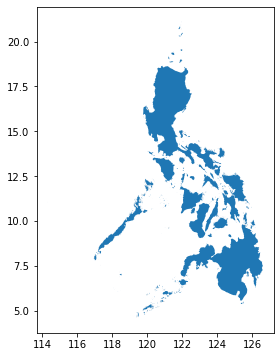

In [5]:
ph_gdf.plot(figsize = (6,6))
plt.show()

In [6]:
ph_bbox = gpd.GeoSeries(box(*ph_gdf.total_bounds), crs = "epsg:4326")
ph_bbox

0    POLYGON ((126.60496 4.58729, 126.60496 21.1218...
dtype: geometry

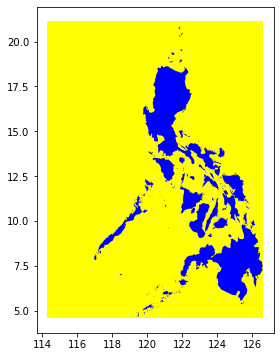

In [7]:
fig, ax = plt.subplots(figsize = (6,6))
ph_bbox.plot(ax = ax, color = "yellow")
ph_gdf.plot(ax = ax, color = "blue")
plt.show()

In [8]:
nl_raster = rioxarray.open_rasterio(nl_raster_filepath, masked = True)
nl_raster

<xarray.DataArray (band: 1, y: 33601, x: 86401)>
[2903160001 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 75.0 75.0 74.99 74.99 ... -64.99 -64.99 -65.0 -65.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

# Raster Clipping using a GeoDataFrame

[Tutorial for Clipping Rasters using rioxarray](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html)

In [9]:
%%time
# from disk since the raster is a large file (11 GB)
clip_nl_raster = nl_raster.rio.clip(ph_bbox, ph_bbox.crs, from_disk = True)
clip_nl_raster

CPU times: user 223 ms, sys: 1.22 s, total: 1.45 s
Wall time: 4.65 s


<xarray.DataArray (band: 1, y: 3969, x: 2959)>
array([[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [13.282721 , 13.382282 , 13.98126  , ...,  0.       ,
          0.       ,  0.       ],
        [19.472155 ,  8.34418  ,  7.1606784, ...,  0.       ,
          0.       ,  0.       ],
        [11.771265 ,  5.55584  ,  3.9778295, ...,  0.       ,
          0.       ,  0.       ]]], dtype=float32)
Coordinates:
  * x            (x) float64 114.3 114.3 114.3 114.3 ... 126.6 126.6 126.6 126.6
  * y            (y) float64 21.12 21.12 21.11 21.11 ... 4.6 4.596 4.592 4.587
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [10]:
clip_nl_raster.rio.to_raster(f"output/clipped_ph_nl_median_masked_{year}.tif")

In [ ]:
nl_raster.nodata